# Лабораторная работа № 7

**Вариант:** 14

## Предсказание пола клиента по транзакциям

### Описание задачи

Одним из самых ценных источников информации о клиенте являются данные о банковских транзакциях. В этом задании предлагается ответить на вопрос: возможно ли предсказать пол клиента, используя сведения о поступлениях и тратах по банковской карте? И если возможно, то какая точность такого предсказания?

Оригинальная постановка задачи: https://www.kaggle.com/competitions/python-and-analyze-data-final-project

### Описание данных

**transactions.csv** - таблица содержит историю транзакций клиентов банка за один год и три месяца.

* customer_id - идентификатор клиента

* tr_datetime - день и время совершения транзакции (дни нумеруются с начала данных)

* mcc_code - mcc-код транзакции

* tr_type - тип транзакции

* amount - сумма транзакции в условных единицах; со знаком "+" — начисление средств клиенту (приходная транзакция), "-" — списание средств (расходная транзакция)

* term_id - идентификатор терминала

**gender_train.csv** - таблица содержит информацию по полу для части клиентов, для которых он известен.

* customer_id - идентификатор клиента

* gender - пол клиента

**gender_test_kaggle_sample_submission.csv** - пример файла для загрузки решения на Kaggle. Структура таблицы аналогична gender_train.csv

**tr_mcc_codes.csv** - таблица содержит описание mcc-кодов транзакций.

* mcc_code - mcc-код транзакции
* mcc_description - описание mcc-кода транзакции

**tr_types.csv** - таблица содержит описание типов транзакций.

* tr_type - тип транзакции
* tr_description - описание типа транзакции

**gender_pred_sample.csv** - пример файла решения.

* customer_id - идентификатор клиента
* probability - вероятность принадлежности к полу "1"

In [2]:
import pandas as pd
import numpy as np

import xgboost as xgb
import re
import matplotlib.pyplot as plt

#from tqdm.notebook import tqdm_notebook
from warnings import filterwarnings

%matplotlib inline
filterwarnings('ignore')

### Подготовка данных

In [2]:
# Считываем данные
tr_mcc_codes = pd.read_csv('./data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('./data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('./data/transactions.csv', index_col='customer_id')
transactions.describe()

,mcc_code,tr_type,amount
count,6.849346e+06,6.849346e+06,6.849346e+06
mean,5.589776e+03,2.517356e+03,-2.054285e+04
std,6.035857e+02,2.270108e+03,4.777528e+05
min,7.420000e+02,1.000000e+03,-1.459845e+08
25%,5.200000e+03,1.030000e+03,-2.245916e+04
50%,5.641000e+03,1.110000e+03,-5.480030e+03
75%,6.010000e+03,2.370000e+03,-1.122960e+03
max,9.402000e+03,8.146000e+03,1.459845e+08


In [3]:
gender_train = pd.read_csv('./data/gender_train.csv', index_col='customer_id')
gender_test = pd.DataFrame(columns=['gender'], index = list(set(transactions.index) - set(gender_train.index)))
# gender_test = pd.read_csv('./data/gender_test_kaggle_sample_submission.csv', index_col='customer_id')

transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

In [4]:
print(f'Всего уникальных клиентов: {transactions.index.nunique()}')
print(f'Всего уникальных клиентов с известным полом (train): {transactions_train.index.nunique()}')
print(f'Всего уникальных клиентов с неизвестным полом (test): {transactions_test.index.nunique()}')

Всего уникальных клиентов: 15000
Всего уникальных клиентов с известным полом (train): 8400
Всего уникальных клиентов с неизвестным полом (test): 6600


### Формирование признаков

In [5]:
# Добавим дополнительные признаки по каждому пользователю в модель.
# Для этого будем анализировать дни недели, часы и состояние дня/ночи.
for df in [transactions_train, transactions_test]:
    df['weekday'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['isday'] = df['hour'].between(6, 22).astype(int)

transactions_train.sample

<bound method NDFrame.sample of               tr_datetime  mcc_code  tr_type     amount   term_id  gender  \
customer_id                                                                 
22899          1 15:26:45      4814     1030   -4491.83       NaN       1   
22899          2 20:52:48      4814     1030   -2245.92       NaN       1   
22899          5 18:52:19      6011     2010  -44918.32       NaN       1   
22899          6 12:28:22      6011     2010 -150476.36       NaN       1   
22899         28 10:41:01      6010     7030   33688.74       NaN       1   
...                   ...       ...      ...        ...       ...     ...   
99999680     444 00:00:00      5411     1110   -5659.71  31190432       1   
99999680     444 00:00:00      6011     2110 -134754.95    406826       1   
99999680     446 00:00:00      5541     1110  -11229.58   J038003       1   
99999680     451 09:56:17      6010     7070    1122.96    945022       1   
99999680     456 06:28:00      4814     1030

In [6]:
def features_creation(x): 
    '''Формирование признаков по каждому пользователю'''
    
    features = []

    # ВременнЫе признаки
    features.append(pd.Series(x['weekday'].value_counts(normalize=True).add_prefix('weekday_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['isday'].value_counts(normalize=True).add_prefix('isday_')))
    
    # Стандартные агрегации, посчитанные на расходах и приходах клиента: 
    # минимум, максимум, среднее, медиана, среднеквадратичное отклонение, количество
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))

    # Типы транзакций 
    #features.append(pd.Series(x['mcc_code'].value_counts(normalize=True).add_prefix('mcc_code_')))
    # Типы mcc кодов
    #features.append(pd.Series(x['tr_type'].value_counts(normalize=True).add_prefix('tr_type_')))

    # ДОПОЛНИТЕЛЬНЫЕ ПАРАМЕТРЫ
    # ....
    
    return pd.concat(features)

In [7]:
data_train = transactions_train.groupby(transactions_train.index).apply(features_creation).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index).apply(features_creation).unstack(-1)

### Построение модели

Функции, которыми можно пользоваться для построения классификатора, оценки его результатов и построение прогноза для тестовой части пользователей

In [8]:
def cv_score(params, train, y_true):
    '''Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)'''
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print(f'Cross-validation, ROC AUC: {cv_res.loc[index_argmax]["test-auc-mean"]:.3f}+-{cv_res.loc[index_argmax]["test-auc-std"]:.3f}')
    print(f'Trees: {index_argmax}')

In [9]:
def fit_predict(params, num_trees, train, test, target):
    '''Построение модели + возврат результатов классификации тестовых пользователей'''
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    return clf, submission

In [10]:
def draw_feature_importances(clf, top_k=10):
    '''Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
    в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
    '''
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

In [11]:
# Стандартные параметры модели
# !!! Здесь можно и НУЖНО экспериментировать

params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

### Построение решения

In [17]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

Cross-validation, ROC AUC: 0.683+-0.006
Trees: 78


In [18]:
### Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 180, data_train, data_test, target)

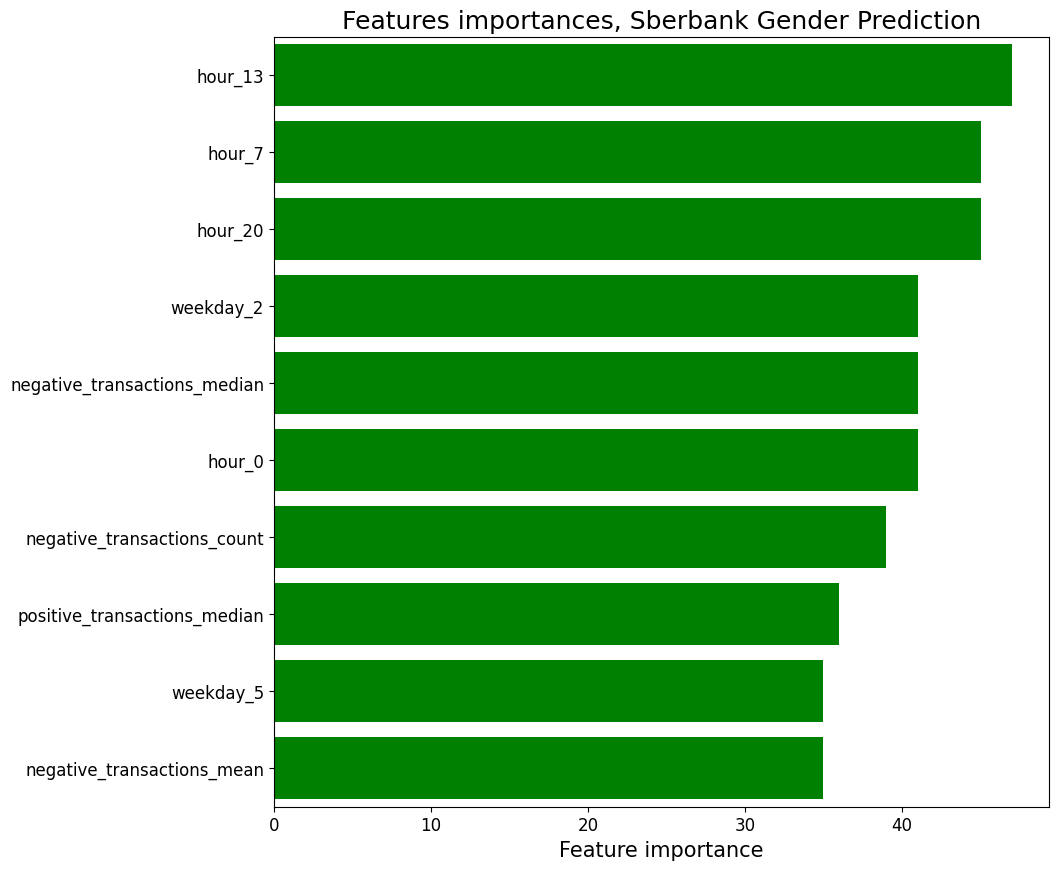

In [19]:
draw_feature_importances(clf, 10)

In [20]:
# В итоге можем отправить полученное решение на платформу Kaggle. 
# Для этого выгрузим его в *.csv - файл, после чего полученный файл можем загружать в качестве ответа.
submission.to_csv('./data/submission.csv')

In [5]:
dataset = pd.read_csv('./data/transactions.csv')
dataset.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN


In [15]:
dataset['tr_date'] = dataset['tr_datetime'].apply(lambda x: int(x.split()[0]))

# Просмотрим измененный набор данных
dataset.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,tr_date
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,0
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,1
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,2


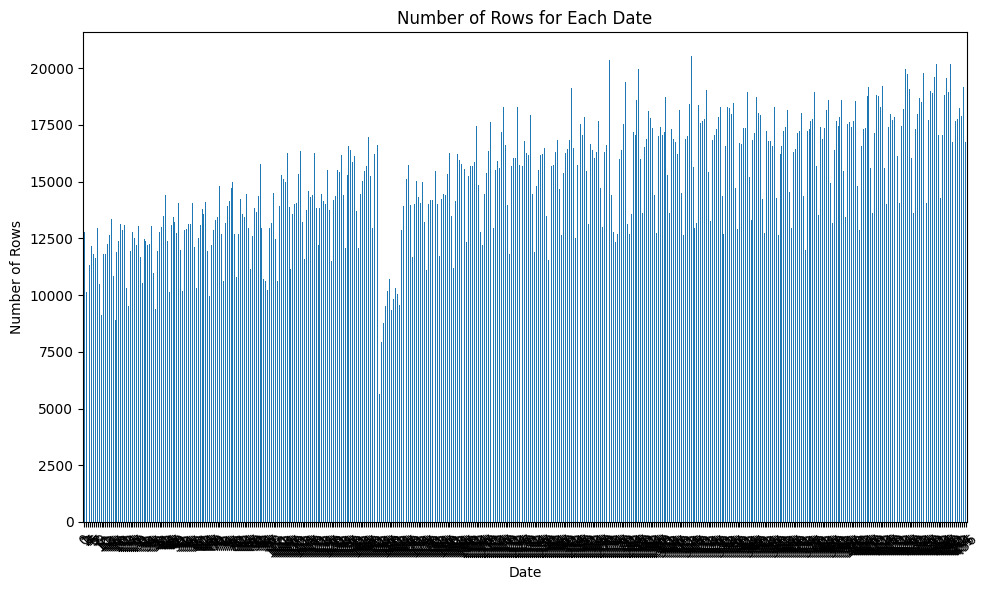

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных из CSV файла
#data = pd.read_csv('путь_к_вашему_файлу.csv')

# Преобразование столбца с датой в формат datetime
#data['Date'] = pd.to_datetime(data['Date'])

# Подсчет числа строк для каждой даты
date_counts = dataset['tr_date'].value_counts().sort_index()

# Построение графика
plt.figure(figsize=(10, 6))
date_counts.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Number of Rows')
plt.title('Number of Rows for Each Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Задания

### Задание 1. Связать номер дня с календарем.

Т.е. определить дату начала наблюдений

In [20]:
transactions = pd.read_csv('./data/transactions.csv')
transactions

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN
...,...,...,...,...,...,...
6849341,61870738,453 16:03:02,5499,1010,-5176.84,10217113
6849342,61870738,454 10:54:60,5411,1010,-1652.77,022915
6849343,61870738,454 14:23:59,5499,1010,-4687.23,10217113
6849344,61870738,454 16:11:53,5541,1110,-4491.83,RU570124


Здесь нас интересует столбец tr_datetime (а именно  день совершения транзакции) и число танзакций, совершенных в этот день. Составим новую таблицу.

In [22]:
transactions['day_number'] = transactions['tr_datetime'].apply(lambda x: int(x.split()[0])) ## выделяем только день, время убираем

grouped_by_day = transactions.groupby('day_number').agg({'amount': 'count'})
grouped_by_day

,amount
day_number,
0,12797
1,10143
2,8845
3,11321
4,12142
...,...
452,17749
453,18262
454,17910


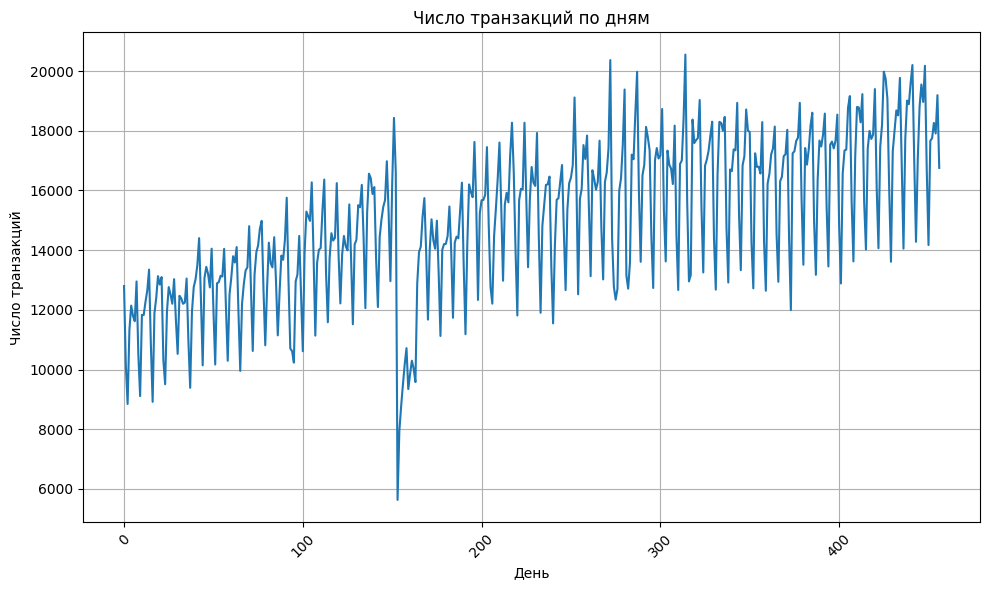

In [14]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(grouped_by_day.index, grouped_by_day['amount'])
plt.title('Число транзакций по дням')
plt.xlabel('День')
plt.ylabel('Число транзакций')
plt.xticks(rotation=45)  
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
day_of_min_transactions = grouped_by_day['amount'].idxmin()
print(f"День с самым маленьким числом транзакций: {day_of_min_transactions}")

День с самым маленьким числом транзакций: 153


На графике можно заметить в одном месте, что число транзакций сначала растет, а потом резко падает. Можно предположить, что это переход от 31 декабря к 1 января. Обозначим 153 условный день за 1 января. Проверим наше предположение по mcc-коду транзакции 5992 (Флористика).

Насколько мы знаем, цветы - популярный подарок на 8 марта. Между 1 января и 8 марта 66 дней, значит 8 марта это 153 + 66 = 219 условный день. Проверим.

In [25]:
filtered_df = transactions[transactions['mcc_code'] == 5992]
grouped_by_day_flower = filtered_df.groupby('day_number').agg({'amount': 'count'})
grouped_by_day_flower

,amount
day_number,
0,12
1,9
3,7
4,9
5,9
...,...
452,12
453,17
454,8


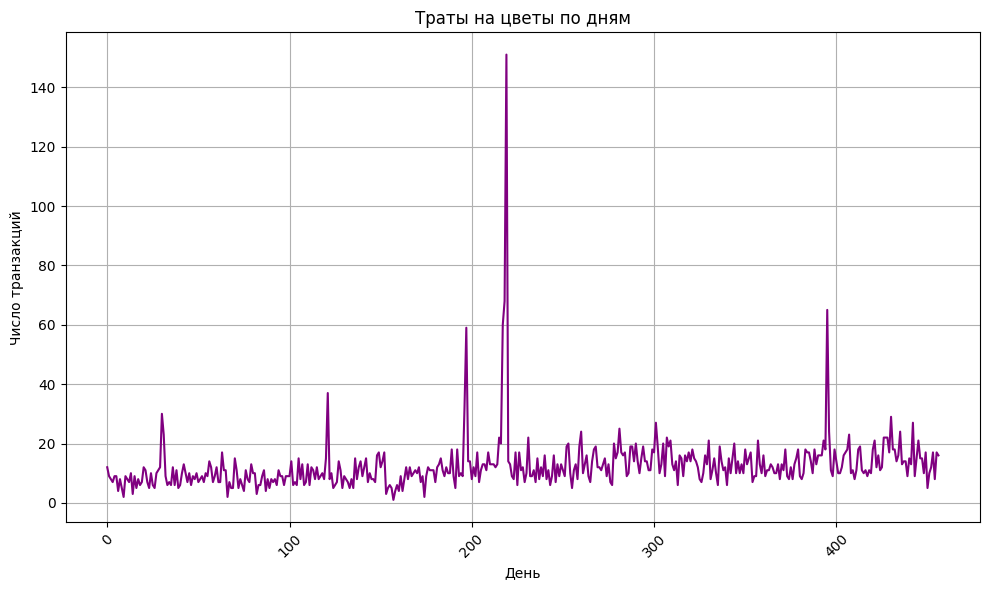

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(grouped_by_day_flower.index, grouped_by_day_flower['amount'], color = 'purple')
plt.title('Траты на цветы по дням')
plt.xlabel('День')
plt.ylabel('Число транзакций')
plt.xticks(rotation=45)  
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
day_of_max_transactions_flower = grouped_by_day_flower['amount'].idxmax()
print(f"День с самой высокой тратой на цветы: {day_of_max_transactions_flower}")

День с самой высокой тратой на цветы: 219


Таким образом, ***153 условный день - 1 января***, как мы и предполагали. Теперь соотнесем даты с днями недели.

In [53]:
filtered_pivo = transactions[(transactions['mcc_code'] == 5813) | (transactions['mcc_code'] == 5921)]
grouped_by_day_pivo = filtered_pivo.groupby('day_number').agg({'amount': 'count'})
grouped_by_day_pivo_march = grouped_by_day_pivo.loc[grouped_by_day_pivo.index.isin(range(0, 90))]
grouped_by_day_pivo_march

,amount
day_number,
0,118
1,142
2,98
3,95
4,97
...,...
85,182
86,100
87,97


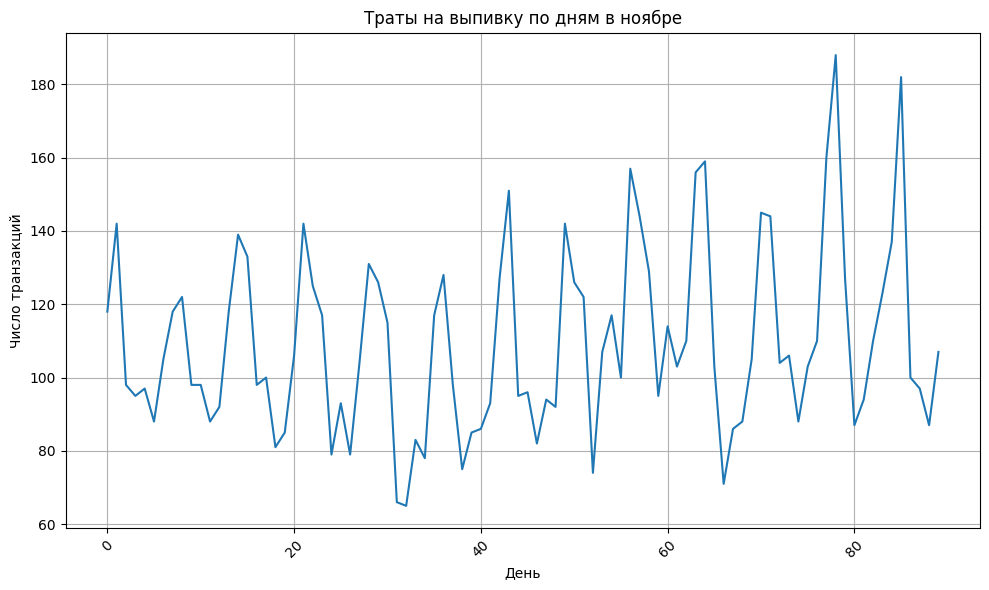

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(grouped_by_day_pivo_march.index, grouped_by_day_pivo_march['amount'])
plt.title('Траты на выпивку по дням в ноябре')
plt.xlabel('День')
plt.ylabel('Число транзакций')
plt.xticks(rotation=45)  
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
fridays = grouped_by_day_pivo_march[grouped_by_day_pivo_march['amount'] > 117].index

print("Предположительные пятницы:", fridays)

Предположительные пятницы: Index([ 0,  1,  7,  8, 13, 14, 15, 21, 22, 28, 29, 36, 42, 43, 49, 50, 51, 56,
       57, 58, 63, 64, 70, 71, 77, 78, 79, 83, 84, 85],
      dtype='int64', name='day_number')


Вероятнее всего $0, 7, 14, 21, 28$ и т.д. - это пятницы, а $1, 15, 22$ и т.д. - это субботы. Делаем вывод, что 0 - это пятница 1 августа. В 2003, 2008 и 2014 годах 1 августа в пятницу. 2008 отметаем, т.к. у нас не високосный год (т.к.в високосном году добавляется еще один день - 29 февраля, а значит разница между новым годом и 8 марта была бы 67), значит остается 2003 и 2014 год. Т.к. сервис «Электронная Сберкасса» (в будущем "Сбербанк онлайн") был запущен в апреле 2008 года, значит, вариант с 2003 годом нам не подходит. Соответственно, в наших наборах данных транзакции за ***2014-2015 годы***, а ***0 условный день - 1 августа 2014 года***.

### Задание 2. Декодировать суммы поступлений и списаний.

Подсказка: сумма транзакции в условных единицах (amount) получена из реальной суммы транзакции умноженной на некий "секретный" коэффициент.

Попробуем найти коэффициент при помощи типа транзакции 2010 - Выдача наличных в АТМ Сбербанк России. Чаще всего в банкомате берут целые купюры (круглую сумму).

In [66]:
transactions[transactions['tr_type'] == 2010].sort_values(by='amount', ascending=False)

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day_number
5039933,89808284,318 01:23:12,6011,2010,786070.52,80464,318
5039930,89808284,318 01:23:25,6011,2010,786070.52,80464,318
4211047,66358761,349 00:00:00,6011,2010,399773.01,10042243,349
1732778,53194608,78 14:30:38,6011,2010,336887.37,NaN,78
89147,59412639,99 11:30:52,6011,2010,224591.58,NaN,99
...,...,...,...,...,...,...,...
4674467,95303296,389 10:05:26,6011,2010,-4491831.54,10075982,389
1087471,76310395,418 13:26:12,6011,2010,-4491831.54,645588,418
3899803,45890327,441 15:39:40,6011,2010,-4491831.54,381919,441
5245301,47577577,382 20:07:35,6011,2010,-4491831.54,551637,382


In [68]:
transactions[transactions['tr_type'] == 2010].groupby('amount').agg({'amount': 'count'}).rename(columns={'amount': 'count'}).sort_values(by='count', ascending=False).head(10)

,count
amount,
-22459.16,114203
-11229.58,106935
-44918.32,78444
-67377.47,63183
-89836.63,47912
-8983.66,44379
-4491.83,39590
-112295.79,39403
-6737.75,38868


Можем предположить, что 2245.92 - это 100 рублей, 22459.16 - 1000 рублей, 11229.58 - 500 рублей и т.д. Таким образом, искомый коэффициент ***22.4592***

### Задание 3. Соотнести 0 и 1 к полу

Определим пол по числу транзакций. Мы пока не знаем, кто является 0, а кто 1. Возьмем наиболее близкие траты для женщин, такие как косметика, шоппинг и т.д. Начнем с 5977 - Магазины косметики.

In [72]:
people_df = pd.read_csv('./data/gender_train.csv')
merged_table = pd.merge(transactions, people_df, on='customer_id')
merged_table

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day_number,gender
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,0,1
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,1,1
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1,1
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1,1
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,2,1
...,...,...,...,...,...,...,...,...
3751078,61870738,453 16:03:02,5499,1010,-5176.84,10217113,453,0
3751079,61870738,454 10:54:60,5411,1010,-1652.77,022915,454,0
3751080,61870738,454 14:23:59,5499,1010,-4687.23,10217113,454,0
3751081,61870738,454 16:11:53,5541,1110,-4491.83,RU570124,454,0


In [80]:
cosmetics = merged_table[merged_table['mcc_code'] == 5977] 
cosmetics.drop_duplicates(subset='customer_id', inplace=True)
cosmetics

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day_number,gender
2140,1585299,90 09:42:30,5977,1010,-3571.68,NaN,90,1
3035,5524414,423 09:18:22,5977,1010,-2335.75,083385,423,0
3276,35059129,76 14:31:42,5977,1010,-4491.83,NaN,76,0
4387,3765322,95 18:54:19,5977,1110,-49072.59,NaN,95,0
6194,41870088,138 19:36:24,5977,1110,-48498.31,NaN,138,1
...,...,...,...,...,...,...,...,...
3745166,93176546,7 13:40:08,5977,1010,-16080.76,NaN,7,1
3745905,22566303,54 00:00:00,5977,1110,-11386.79,NaN,54,0
3747280,53455317,388 00:00:00,5977,1110,-2964.61,00350234,388,0
3748871,90011720,126 15:48:31,5977,1110,-42649.94,NaN,126,0


In [83]:
gender_1_c = (cosmetics['gender'] == 1).sum()
gender_0_c = (cosmetics['gender'] == 0).sum()

print('0:', gender_0_c, '1:', gender_1_c)

0: 2294 1: 1111


Как мы видим покупок косметики больше у гендера 0. Смею предположить, это и есть женщины. Проверим наше предположение на 5631 - Аксессуары для женщин

In [82]:
accessories = merged_table[merged_table['mcc_code'] == 5631] 
accessories.drop_duplicates(subset='customer_id', inplace=True)
accessories

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day_number,gender
3878,35059129,303 00:00:00,5631,1110,-6063.97,20454635,303,0
4814,3765322,377 17:02:02,5631,1110,-66771.08,26303362,377,0
10951,64294802,204 00:00:00,5631,1110,-12240.24,NaN,204,1
23488,2368868,12 16:24:04,5631,1010,-30656.75,NaN,12,0
26967,3180911,13 16:58:22,5631,1010,-2021.32,NaN,13,0
...,...,...,...,...,...,...,...,...
3728121,49446707,420 00:00:00,5631,1110,-67377.47,26303891,420,1
3738788,42445327,287 22:02:45,5631,1010,-35912.19,241140,287,0
3740156,87780866,225 00:00:00,5631,1110,-1482.30,29039219,225,0
3743844,9745595,376 15:52:46,5631,1110,-44806.02,50122942,376,0


In [84]:
gender_1_a = (accessories['gender'] == 1).sum()
gender_0_a = (accessories['gender'] == 0).sum()

print('0:', gender_0_a, '1:', gender_1_a)

0: 664 1: 205


Здесь тоже видим, что гендер 0 в большей степени тратится на женские аксессуары. Проверим также 5621- Готовая женская одежда.

In [86]:
clothes = merged_table[merged_table['mcc_code'] == 5621] 
clothes.drop_duplicates(subset='customer_id', inplace=True)
clothes

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day_number,gender
828,39026145,372 08:45:27,5621,1010,-31442.82,097179,372,1
2705,1585299,407 10:38:46,5621,1010,-57158.56,303501,407,1
4267,3765322,3 16:41:55,5621,1110,-41470.83,NaN,3,0
9103,39472448,233 11:23:40,5621,1010,-168443.68,847130,233,0
10788,64294802,126 10:12:42,5621,1010,-5165.61,NaN,126,1
...,...,...,...,...,...,...,...,...
3742000,42396248,148 20:43:12,5621,1010,-13453.04,NaN,148,0
3742475,95752671,63 15:50:08,5621,1010,-51588.69,NaN,63,0
3743203,91906022,145 13:45:54,5621,1110,-87590.72,NaN,145,0
3744095,31916733,178 00:00:00,5621,1110,-29151.99,NaN,178,1


In [87]:
gender_1_cl = (clothes['gender'] == 1).sum()
gender_0_cl = (clothes['gender'] == 0).sum()

print('0:', gender_0_cl, '1:', gender_1_cl)

0: 1297 1: 424


Делаем вывод: ***0 - женщины, 1 - мужчины***